In [44]:
# import dependencies
import os
import pandas as pd
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

SCA_dset_dir = "dataset/SCA"
SCW_dset_dir = "dataset/SCW"

## SCA Dataset


**🌬️ SensiChips – SCA Air Sensor Dataset**

**Date:** April 22, 2024  
**Sensors:** SnO₂+Au (TCO) & Al₂O₃ (VCO)  
**Frequencies:** 78.1 kHz & 200 Hz  
**Format:** `.csv`

---

**📊 Data Overview**

- **TCO (Temp. Cycled Operation)**  
  SnO₂+Au sensor at 6 temps (150–400°C)  
  IN-PHASE @ 78.1kHz & 200Hz (12 acquisitions)

- **VCO (Volt. Cycled Operation)**  
  Al₂O₃ sensor at 2 voltages  
  IN-PHASE + QUADRATURE @ 78.1kHz (4 acquisitions)

---

**📁 Folder Structure**

- `TRAINING/` – Experiments on 15 chemicals (~200 samples each)  
- `NORMALIZED/` – Baseline-adjusted version of RAW  

Each of it has:
- `RAW/` – 16-bit ADC data (`-32768` to `32767`)  
- `TEST/` – Random/turbulent conditions for validation

---

For ML use: classify varying concentrations from sensor signals.


#### Building new DataFrame

In [37]:
all_data = []

for split in ['TEST', 'TRAINING']:
    split_dir = os.path.join(SCA_dset_dir, split, "NORMALIZED")
    
    for label in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label)
        
        for filename in os.listdir(label_dir):
            if filename.endswith('.csv'):
                exp_name = filename.split('.')[0]
                file_path = os.path.join(label_dir, filename)

                df = pd.read_csv(file_path, sep=';')
                df['SPLIT'] = split
                df['EXP_NAME'] = exp_name
                all_data.append(df)

# Combine all dataframes into one
full_df = pd.concat(all_data, ignore_index=True)

# 🔍 Count NaNs before dropping
nan_counts = full_df.isna().sum()
total_nans = nan_counts.sum()
nan_rows_before = full_df.shape[0]
nan_rows = full_df.dropna().shape[0]

# 🧹 Drop rows with NaN
full_df_clean = full_df.dropna()

# 💾 Save the cleaned dataset
full_df_clean.to_csv(os.path.join(SCA_dset_dir, "SCA_dset.csv"), index=False)

# 🖨️ Report
print("✅ Cleaned dataset saved.")
print(f"🧼 Total NaN values found: {total_nans}")
print(f"🧾 NaN values per column:\n{nan_counts[nan_counts > 0]}")
print(f"🧨 Rows deleted: {nan_rows_before - nan_rows}")
print(f"📊 Final dataset shape: {full_df_clean.shape}")

✅ Cleaned dataset saved.
🧼 Total NaN values found: 20
🧾 NaN values per column:
OFFCHIP_SENSIMOX_SnAu_150_200.0_IN-PHASE    10
OFFCHIP_SENSIMOX_SnAu_200_200.0_IN-PHASE     3
OFFCHIP_SENSIMOX_SnAu_250_200.0_IN-PHASE     2
OFFCHIP_SENSIMOX_SnAu_350_200.0_IN-PHASE     3
ONCHIP_ALUMINUM_OXIDE_OUT4_QUADRATURE        2
dtype: int64
🧨 Rows deleted: 16
📊 Final dataset shape: (266984, 19)


**🧾 Combined SCA Dataset**

**Path:** `dataset/SCA/SCA_dset.csv` (Size: 43 MB)  
This file merges all normalized `.csv` measurements from the original TRAINING and TEST sets.

**📐 Structure**

Each row represents a single impedance measurement.

**📄 Columns**
- 16 Sensor features from the original files  
- `LABEL` – Ground truth chemical substance  
- `EXP_NAME` – Original experiment file name (without `.csv`)  
- `SPLIT` – Source set: `TRAINING` or `TEST`


### Dataset Analysis

In [38]:
full_df = pd.read_csv(os.path.join(SCA_dset_dir, "SCA_dset.csv"))

#### Feature Correlation

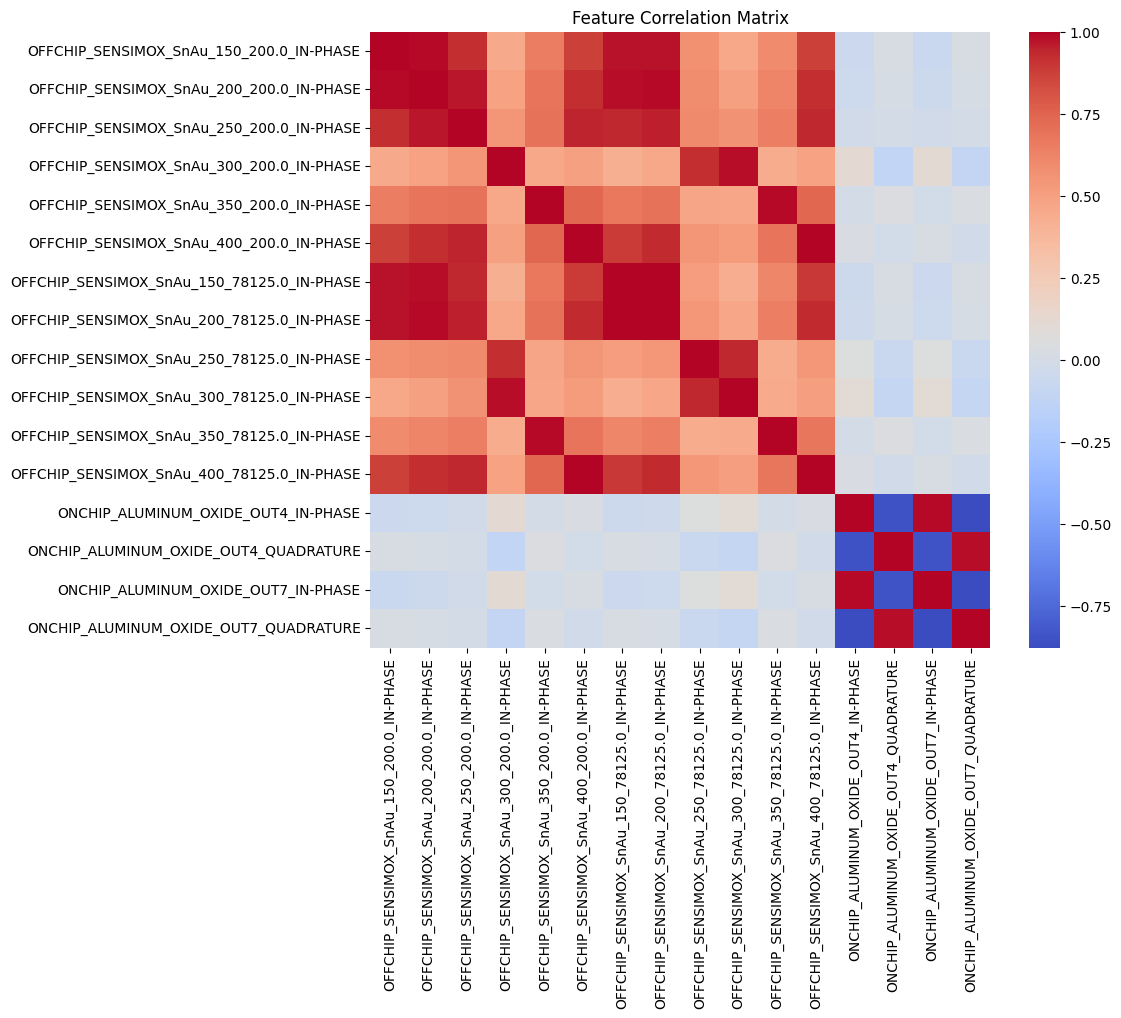

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(full_df.iloc[:, :16].corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

**🔍 Feature Correlation Matrix**

The heatmap shows the correlation between the 16 impedance features of the SCA dataset:

- The **SnO₂+Au sensor features** (left block) show **strong positive correlations** across temperatures and frequencies, indicating similar response patterns under TCO conditions.
- The **Al₂O₃ sensor features** (right block) exhibit **strong internal correlations** (both in-phase and quadrature), but **low or negative correlation** with the SnO₂+Au features, confirming their different sensing behavior under VCO conditions.
- This separation suggests that the two sensor types contribute **complementary information**, useful for multi-sensor classification models.


#### Label Distribution

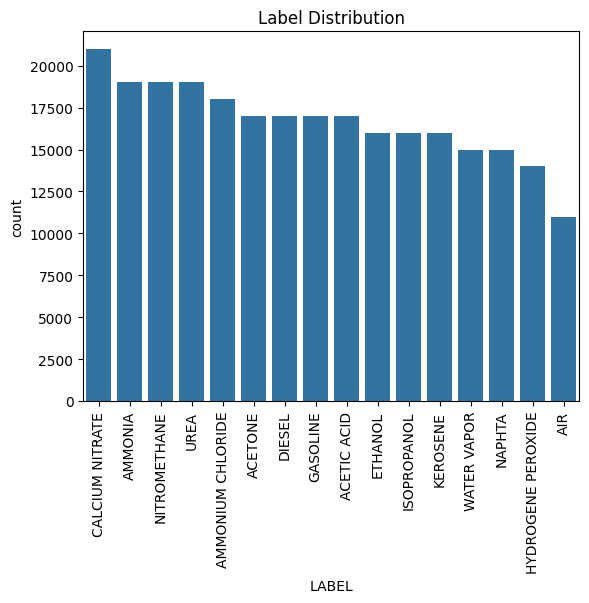

In [40]:
sns.countplot(data=full_df, x="LABEL", order=full_df["LABEL"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Label Distribution")
plt.show()

#### PCA 3D

In [ ]:
X = full_df.iloc[:, :16]
y = full_df["LABEL"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

full_df["PC1"] = X_pca[:, 0]
full_df["PC2"] = X_pca[:, 1]
full_df["PC3"] = X_pca[:, 2]

full_df.to_csv(os.path.join(SCA_dset_dir, "SCA_dset.csv"), index=False)
print("✅ Dataset saved with PCA components in 'SCA_dset.csv'")

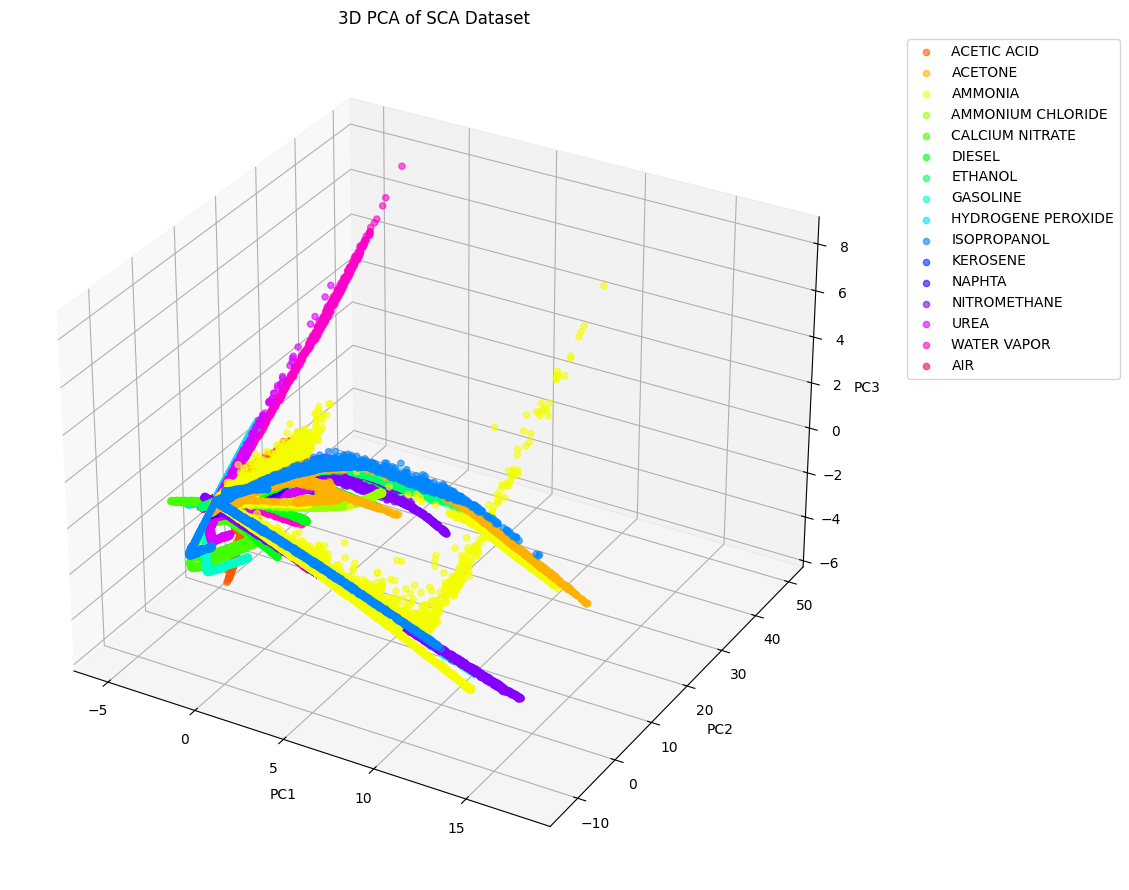

In [48]:
unique_labels = full_df["LABEL"].unique()
palette = sns.color_palette("hsv", len(unique_labels))
color_dict = dict(zip(unique_labels, palette))

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    subset = full_df[full_df["LABEL"] == label]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"],
               label=label, color=color_dict[label], s=20, alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of SCA Dataset")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

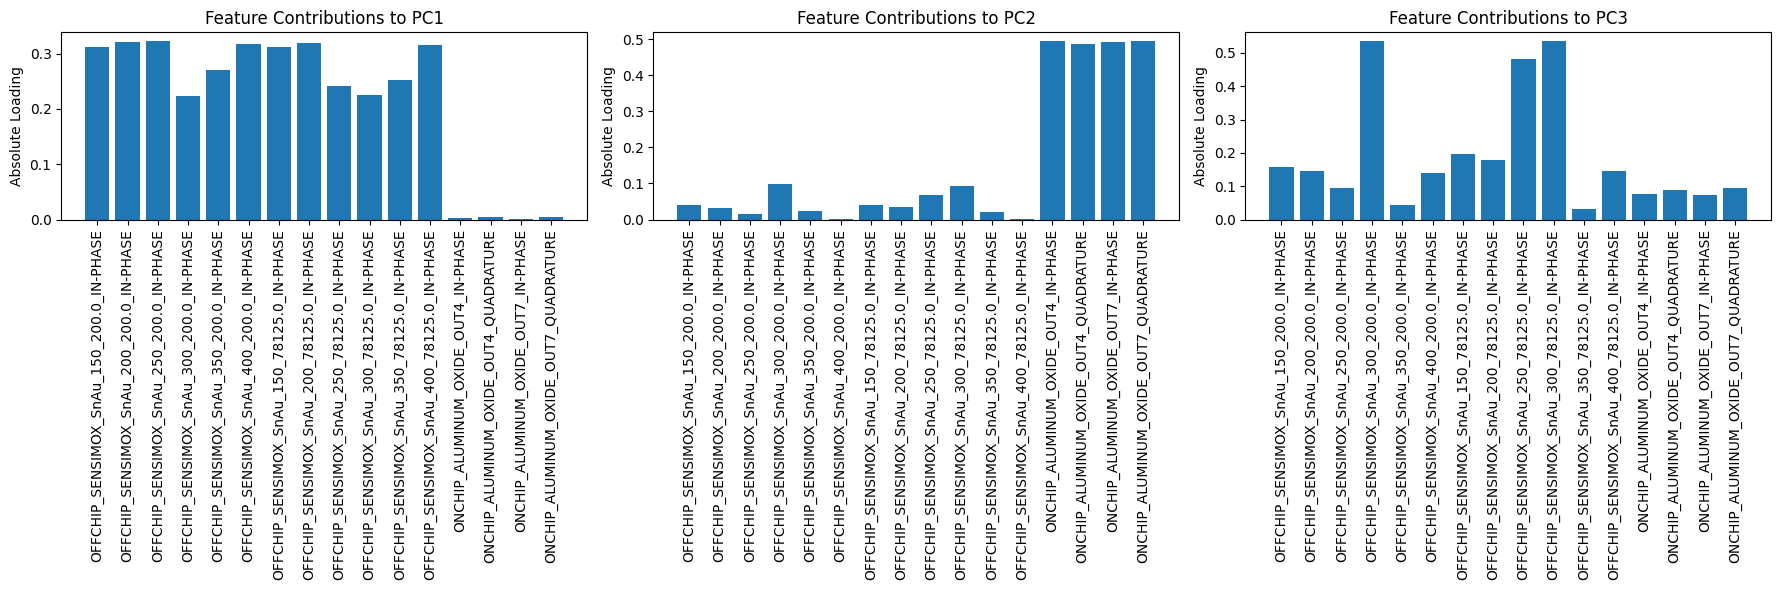

In [49]:
feature_names = full_df.columns[:16]

loadings = pd.DataFrame(pca.components_.T,
                        columns=["PC1", "PC2", "PC3"],
                        index=feature_names)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, pc in enumerate(["PC1", "PC2", "PC3"]):
    axes[i].bar(loadings.index, np.abs(loadings[pc]))
    axes[i].set_title(f"Feature Contributions to {pc}")
    axes[i].set_ylabel("Absolute Loading")
    
    # Fix the tick issue
    axes[i].set_xticks(np.arange(len(loadings.index)))
    axes[i].set_xticklabels(loadings.index, rotation=90)

plt.tight_layout()
plt.show()

## SCW Dataset